In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import math

c:\Users\Julian Unland\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.     0.     0.3125 0.8125 0.5625 0.0625 0.     0.     0.     0.
 0.8125 0.9375 0.625  0.9375 0.3125 0.     0.     0.1875 0.9375 0.125
 0.     0.6875 0.5    0.     0.     0.25   0.75   0.     0.     0.5
 0.5    0.     0.     0.3125 0.5    0.     0.     0.5625 0.5    0.
 0.     0.25   0.6875 0.     0.0625 0.75   0.4375 0.     0.     0.125
 0.875  0.3125 0.625  0.75   0.     0.     0.     0.     0.375  0.8125
 0.625  0.     0.     0.    ]


<Figure size 640x480 with 0 Axes>

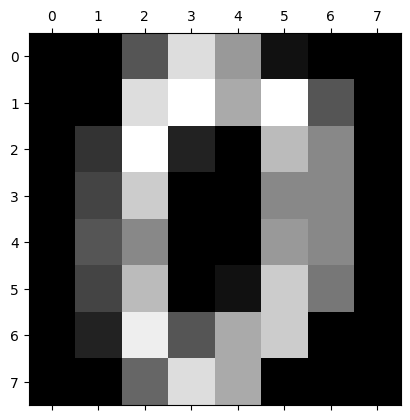

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

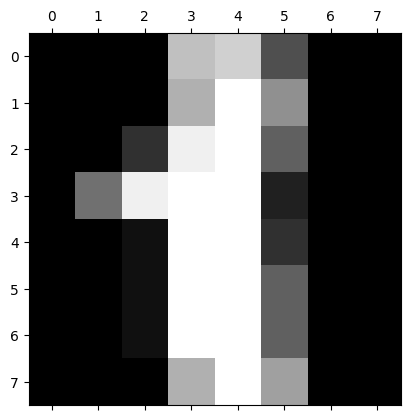

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
# load the digits dataset into a variable
digits = load_digits()

# how many different targets do we have?
target_size = len(digits.target_names)

# 10 -> numbers from 0-9
#print(target_size)

# store the pictures as floating point numpy array of shape (1797, 64) -> 1797 pictures, with 64 pixels each
X = np.array(digits.data, dtype=float)

# store targets as integer numpy array of shape(1797, ) -> 1797 pictures, with 1 label each
y = np.array(digits.target, dtype=int)

# check
# print(X.shape)
# print(y.shape)

# scaling the numbers into a range of [0,1]
X = (X - np.min(X))/(np.max(X)-np.min(X))

# encoding into one hot vectors
# np.eye(target_size) returns the identity matrix
# the index [y] of this identity matrix gives us the row of the identity matrix, in which the 1 is at index y
# 5 -> [0,0,0,0,0,1,0,0,0,0]
# new shape is (1797, 10) -> 1797 pictures with a one hot vector each
y = np.eye(target_size)[y]

# check
# print(y.shape)


def show_img(digits : np.array):
  plt.gray()
  plt.matshow(digits.reshape(8, 8))
  plt.show()

# yield X, y randomly
def shuffle_generator(X : np.array, y : np.array) -> (np.array, np.array):
  # shuffler is np.array with every integer in [0, ..., len(X)] randomly arranged
  shuffler = np.random.permutation(len(X))

  # this shuffles X and y in the same way by taking the order of shuffler
  # X and y are both shuffled, but the indices of both np.arrays still match the same data-target pair
  X = X[shuffler]
  y = y[shuffler]

  # iterate through the indices, starting at 0
  # in each call we yield a data-target pair
  idx = 0
  while idx < len(X):
    yield(X[idx], y[idx])
    idx += 1

print(X[0])
for i in range(2):
  show_img(X[i])
  print(y[i])

In [4]:
# ACTIVATION FUNCTIONS
def sigmoid(input : np.array) -> np.array:
  return 1/(1 + np.exp(-input))

def softmax(input : np.array) -> np.array:
  sum = np.sum(np.exp(input))
  out = np.exp(input) / sum
  return out



  # LOSS FUNCTION
def cross_entropy(predictions : np.array, targets : np.array) -> float:
  return -np.sum(targets * np.log(predictions + 10**-100))


In [5]:
def cross_entropy_backwards(predictions : np.array, targets : np.array) -> np.array:
  return predictions - targets


def sigmoid_backwards(input : np.array) -> np.array:
  return sigmoid(input) * (1 - sigmoid(input))

In [6]:
# Layer Class which represents a layer in the neural network
class MLP_layer():
  def __init__(self,units, input_size, activation_function, activation_function_backwards = 0):
    self.activation_function = activation_function
    self.activation_function_backwards = activation_function_backwards
    self.units = units
    self.input_size = input_size

    self.input = np.zeros(input_size)
    self.preactivation = np.zeros(units)
    self.activation = np.zeros(units)
    self.weights = np.random.normal(0, 0.2, size=(units, input_size))
    self.bias = np.zeros(units)

  def forward(self, input : np.ndarray):
    self.input = input
    self.preactivation = (self.weights @ input) + self.bias
    self.activation = self.activation_function(self.preactivation)
    return self.activation

  def backwards(self, error_signal):
    error_signal = error_signal * self.activation_function_backwards(self.preactivation) # dL/a * da/dpre
    dLdW = np.outer(error_signal, self.input)       # to adjust the weights                dL/dpre * dpre/dW
    dLdinput = error_signal @ self.weights # error signal for the next layer               dL/dpre * dpre/dinput
    return (dLdW, dLdinput)

  def backwards_output(self, targets):
    error_signal = cross_entropy_backwards(predictions=self.preactivation, targets=targets) #dL/dpre

    dLdW = np.outer(error_signal, self.input)       # to adjust the weights                          dL/dpre * dpre/dW
    dLdinput = self.weights.T @ error_signal # error signal for the next layer                dL/dpre * dpre/dinput
    return (dLdW, dLdinput)




In [7]:
class ANN():
  def __init__(self):
    self.layer1 = MLP_layer(32, 64, sigmoid, activation_function_backwards=sigmoid_backwards)
    self.layer2 = MLP_layer(16, 32, sigmoid, activation_function_backwards=sigmoid_backwards)
    self.layer3 = MLP_layer(10, 16, softmax)
    self.layers = [self.layer1, self.layer2, self.layer3]

    self.learning_rate = 0.1

  def forward(self, input):
    prediction = input
    for layer in self.layers:
      prediction = layer.forward(prediction)
    return prediction


  def backwards(self, targets):
    (dLdW, error_signal) = self.layers[-1].backwards_output(targets)
    self.layers[-1].weights -= self.learning_rate * dLdW
    for layer in reversed(self.layers[:-1]):
      (dLdW, error_signal) = layer.backwards(error_signal)
      layer.weights -= self.learning_rate * dLdW



In [8]:
ann = ANN()

def training(ANN, epochs=60):
  loss = []
  acc = []
  for i in range(epochs):
    # training and loss
    gen = shuffle_generator(X, y)
    avg_loss = []
    for (X_temp, y_temp) in gen:
      prediction = ANN.forward(X_temp)
      current_loss = cross_entropy(prediction, y_temp)
      avg_loss.append(current_loss)
      ANN.backwards(y_temp)
    loss.append(sum(avg_loss) / len(avg_loss))

    # accuracy
    gen = shuffle_generator(X, y)
    correct = 0
    total = 0
    for (X_temp, y_temp) in gen:
      total += 1
      prediction = ann.forward(X_temp)
      if np.argmax(prediction) == np.argmax(y_temp):
        correct += 1
    acc.append(correct/total)
  return ann, loss, acc

def plot_loss_epoch(avg_loss, accuracy):
  plt.plot([i for i in range(len(avg_loss))], avg_loss, label="avg_loss")
  plt.plot([i for i in range(len(avg_loss))], accuracy, label="accuracy")
  plt.xlabel("epoch")
  plt.ylabel("numeric value for avg_loss and accuracy")
  plt.legend()

In [9]:
ann, avg_loss, accuracy = training(ann)

[2.205424597787631, 1.993232121693282, 1.8386073680003427, 1.7496825628091945, 1.6872276273842346, 1.6444379898060888, 1.6209947581458808, 1.603110055516295, 1.5925990537867545, 1.5812072228580663, 1.5753656233172766, 1.5677508370546254, 1.5643271329982549, 1.5562008551049125, 1.5530759944994061, 1.5489205917834632, 1.545216829653268, 1.5422228020035882, 1.5400119397368142, 1.536682126585388, 1.5330037654538675, 1.529572822334531, 1.5271454772043886, 1.5247894478435757, 1.5218464334057356, 1.5220763744571244, 1.5181353928529282, 1.518204834940654, 1.5146402394603624, 1.5142627862834783, 1.5118808718442467, 1.5112027055766968, 1.5085450032281402, 1.5073570468223318, 1.5063745826961894, 1.5046136963907915, 1.5037774277318883, 1.5021122459541958, 1.5012248982505, 1.500325356902707, 1.4993984782037033, 1.4974890987354037, 1.4974395701614083, 1.4965790408090287, 1.4953491513585309, 1.4954922107757747, 1.4939766294674397, 1.4936295259555687, 1.492289538205392, 1.4927696298013275, 1.491433149

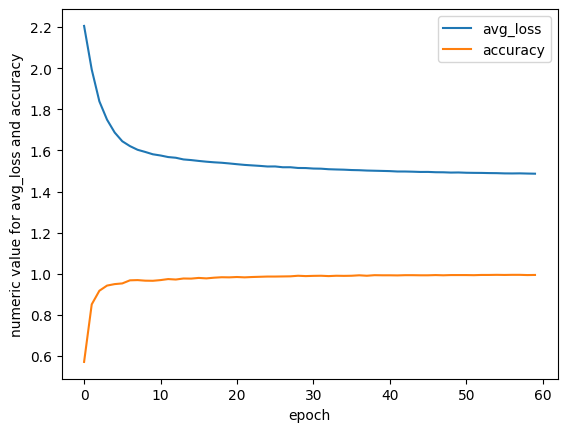

In [10]:
print(avg_loss)
print(accuracy)
plot_loss_epoch(avg_loss, accuracy)

<Figure size 640x480 with 0 Axes>

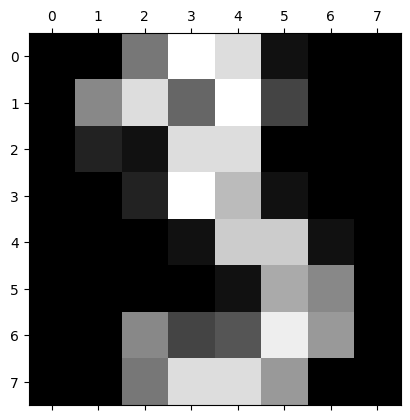

prediction:  3
target:  3


<Figure size 640x480 with 0 Axes>

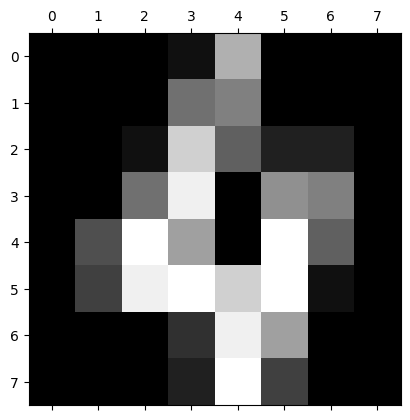

prediction:  4
target:  4


<Figure size 640x480 with 0 Axes>

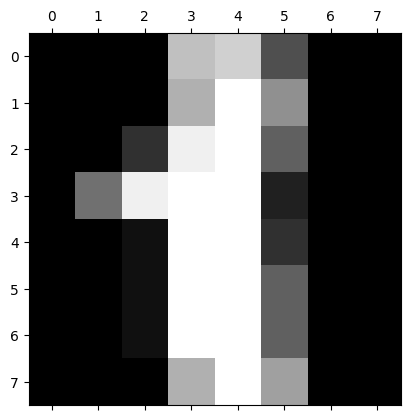

prediction:  1
target:  1


<Figure size 640x480 with 0 Axes>

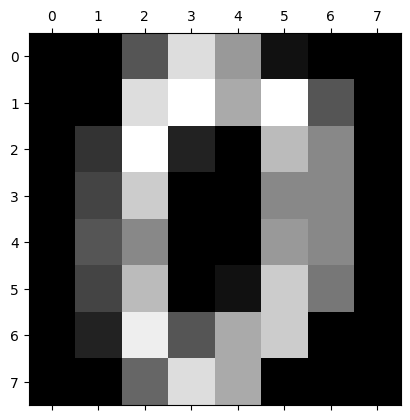

prediction:  0
target:  0


<Figure size 640x480 with 0 Axes>

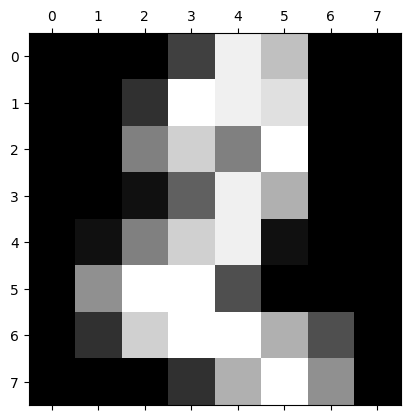

prediction:  2
target:  2


In [14]:
def print_examples(X, y):
    gen = shuffle_generator(X, y)
    for _ in range(5):
        X_ex, y_ex = next(gen)
        show_img(X_ex)
        prediction = ann.forward(X_ex)
        print("prediction: ", np.argmax(prediction))
        print("target: ", np.argmax(y_ex))

print_examples(X[:5], y[:5])